<a href="https://colab.research.google.com/github/raven-gith/machinelearning1/blob/main/Week%206/OnlineRetail.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install dan Import Library
!pip install openpyxl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.spatial.distance import cdist, pdist, squareform


In [3]:
# Load sebagian data (efisien)
from google.colab import files
uploaded = files.upload()

file_path = list(uploaded.keys())[0]

data = pd.read_excel(file_path, usecols=[
    "InvoiceNo", "Quantity", "UnitPrice", "CustomerID", "InvoiceDate"
], nrows=10000)

data.dropna(subset=["CustomerID"], inplace=True)
data["TotalPrice"] = data["Quantity"] * data["UnitPrice"]

Saving Online Retail.xlsx to Online Retail.xlsx


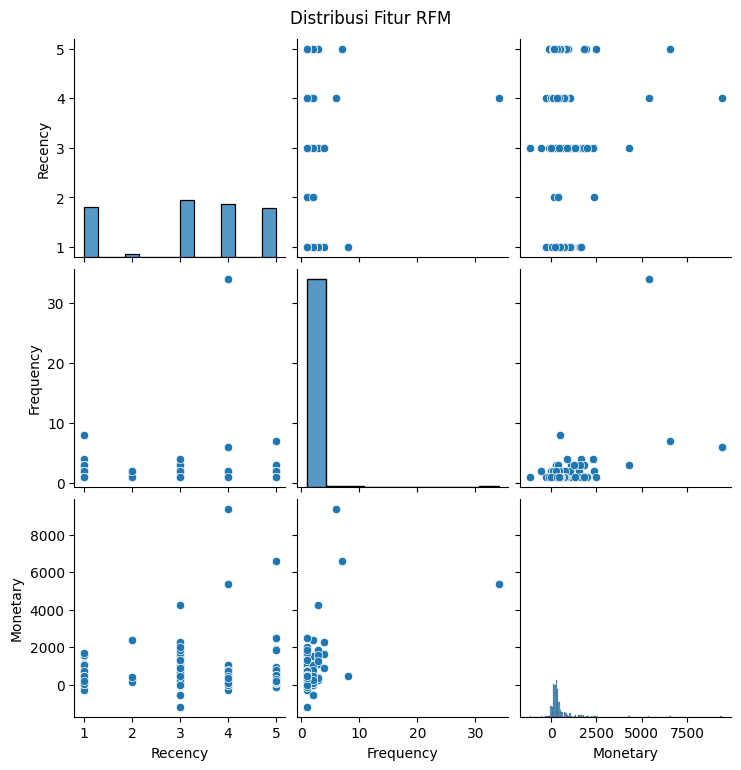

In [5]:
#  fitur RFM

snapshot_date = data["InvoiceDate"].max() + pd.Timedelta(days=1)

rfm = data.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (snapshot_date - x.max()).days,
    "InvoiceNo": "nunique",
    "TotalPrice": "sum"
}).reset_index()

rfm.columns = ["CustomerID", "Recency", "Frequency", "Monetary"]

# Visualisasi awal
sns.pairplot(rfm[["Recency", "Frequency", "Monetary"]])
plt.suptitle("Distribusi Fitur RFM", y=1.02)
plt.show()


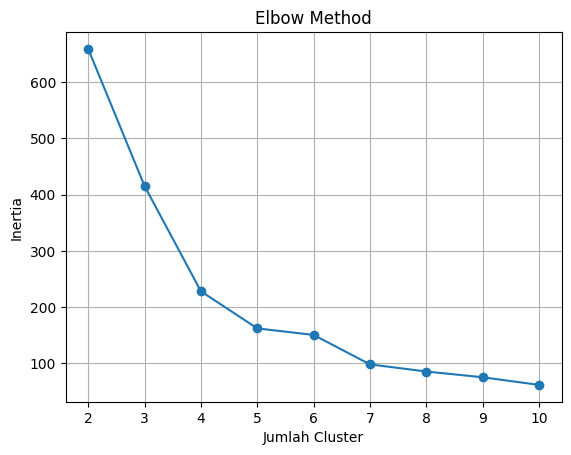

In [6]:
# Clustering

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[["Recency", "Frequency", "Monetary"]])

# Elbow method
inertia = []
K = range(2, 11)
for k in K:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(rfm_scaled)
    inertia.append(model.inertia_)

plt.plot(K, inertia, marker='o')
plt.title("Elbow Method")
plt.xlabel("Jumlah Cluster")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

In [7]:
# Evaluasi KMeans & Agglomerative

k = 3  # berdasarkan Elbow

kmeans = KMeans(n_clusters=k, random_state=42)
agglo = AgglomerativeClustering(n_clusters=k)

kmeans_labels = kmeans.fit_predict(rfm_scaled)
agglo_labels = agglo.fit_predict(rfm_scaled)

def evaluate(X, labels):
    return {
        "Silhouette": silhouette_score(X, labels),
        "Calinski-Harabasz": calinski_harabasz_score(X, labels),
        "Davies-Bouldin": davies_bouldin_score(X, labels),
    }

print("Evaluasi KMeans:", evaluate(rfm_scaled, kmeans_labels))
print("Evaluasi Agglomerative:", evaluate(rfm_scaled, agglo_labels))

Evaluasi KMeans: {'Silhouette': np.float64(0.5411499592409497), 'Calinski-Harabasz': np.float64(213.46399316963664), 'Davies-Bouldin': np.float64(0.45129696715540984)}
Evaluasi Agglomerative: {'Silhouette': np.float64(0.5494475446890758), 'Calinski-Harabasz': np.float64(244.78591659980472), 'Davies-Bouldin': np.float64(0.7984400028343955)}


In [8]:
# Dunn Index (Manual)

def dunn_index(X, labels):
    distances = squareform(pdist(X))
    unique_clusters = np.unique(labels)
    inter_cluster = np.inf
    intra_cluster = 0

    for i in unique_clusters:
        for j in unique_clusters:
            if i < j:
                d = distances[np.ix_(labels == i, labels == j)].min()
                inter_cluster = min(inter_cluster, d)

    for i in unique_clusters:
        d = distances[np.ix_(labels == i, labels == i)]
        if len(d) > 1:
            intra_cluster = max(intra_cluster, d.max())

    return inter_cluster / intra_cluster

print("Dunn Index KMeans:", dunn_index(rfm_scaled, kmeans_labels))
print("Dunn Index Agglomerative:", dunn_index(rfm_scaled, agglo_labels))

Dunn Index KMeans: 0.05247756982881803
Dunn Index Agglomerative: 0.040051279119146285


1. Silhouette Score
Silhouette Score mengukur seberapa mirip suatu data dengan klasternya sendiri dibandingkan dengan klaster lain.
2. Calinski-Harabasz Index
Juga dikenal sebagai Variance Ratio Criterion (VRC), metrik ini mengevaluasi kualitas clustering dengan membandingkan dispersi antar klaster dengan dispersi dalam klaster.
3. Davies-Bouldin Index
Metrik ini mengukur rata-rata kesamaan antara setiap klaster dengan klaster yang paling mirip dengannya, berdasarkan rasio antara dispersi dalam klaster dan jarak antar klaster.
4. Dunn Index
Dunn Index mengevaluasi kualitas clustering dengan membandingkan jarak minimum antar klaster dengan diameter maksimum dari klaster.